In [3]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense


In [4]:
TRAIN_DIR = r"/content/drive/MyDrive/Rice/Rice_Leaf_Diease/train"
TEST_DIR  = r"/content/drive/MyDrive/Rice/Rice_Leaf_Diease/test"

IMG_SIZE = (224, 224)
BATCH_SIZE = 32  # smaller batch = safer RAM


In [5]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

test_datagen = ImageDataGenerator(rescale=1./255)


In [6]:
train_gen = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='sparse',
    subset='training'
)

val_gen = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='sparse',
    subset='validation'
)


Found 11520 images belonging to 10 classes.
Found 2877 images belonging to 10 classes.


In [7]:
test_gen = test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='sparse',
    shuffle=False
)


Found 1586 images belonging to 10 classes.


In [8]:
model = Sequential([
    Conv2D(64, (3,3), activation='relu', input_shape=(224,224,3)),
    MaxPooling2D(2,2),
    Conv2D(32, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Conv2D(32, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Flatten(),
    Dense(10, activation='softmax')
])

model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [9]:
history = model.fit(
    train_gen,
    epochs=5,
    validation_data=val_gen
)


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
360/360 ━━━━━━━━━━━━━━━━━━━━ 4148s 12s/step - accuracy: 0.4144 - loss: 1.6633 - val_accuracy: 0.7181 - val_loss: 0.8867
Epoch 2/5
360/360 ━━━━━━━━━━━━━━━━━━━━ 1721s 5s/step - accuracy: 0.7214 - loss: 0.8194 - val_accuracy: 0.7577 - val_loss: 0.7357
Epoch 3/5
360/360 ━━━━━━━━━━━━━━━━━━━━ 1694s 5s/step - accuracy: 0.8005 - loss: 0.5855 - val_accuracy: 0.7779 - val_loss: 0.6759
Epoch 4/5
360/360 ━━━━━━━━━━━━━━━━━━━━ 1780s 5s/step - accuracy: 0.8659 - loss: 0.4124 - val_accuracy: 0.7470 - val_loss: 0.7304
Epoch 5/5
360/360 ━━━━━━━━━━━━━━━━━━━━ 1742s 5s/step - accuracy: 0.8792 - loss: 0.3632 - val_accuracy: 0.8161 - val_loss: 0.6122


In [10]:
loss, acc = model.evaluate(test_gen)
print("Test Accuracy:", round(acc*100, 2), "%")


50/50 ━━━━━━━━━━━━━━━━━━━━ 629s 13s/step - accuracy: 0.8220 - loss: 0.6276
Test Accuracy: 85.44 %


In [12]:
loss, accuracy = model.evaluate(test_gen)

print("Test Accuracy:", round(accuracy * 100, 2), "%")
print("Test Loss:", round(loss, 4))


50/50 ━━━━━━━━━━━━━━━━━━━━ 92s 2s/step - accuracy: 0.8220 - loss: 0.6276
Test Accuracy: 85.44 %
Test Loss: 0.4507


In [22]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image

img_path = r"/content/drive/MyDrive/Rice/Rice_Leaf_Diease/test/healthy/istockphoto-161820827-612x612.jpg"

img = image.load_img(img_path, target_size=IMG_SIZE)
img_array = image.img_to_array(img) / 255.0
img_array = np.expand_dims(img_array, axis=0)

rslt = model.predict(img_array)

class_labels = list(train_gen.class_indices.keys())
prediction = class_labels[np.argmax(rslt)]
confidence = np.max(rslt) * 100

print("Predicted Disease:", prediction)
print("Confidence:", round(confidence, 2), "%")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
Predicted Disease: healthy
Confidence: 97.36 %


In [23]:
avg_probability = np.mean(rslt[0])
print("Average Prediction Probability:", round(avg_probability, 4))


Average Prediction Probability: 0.1


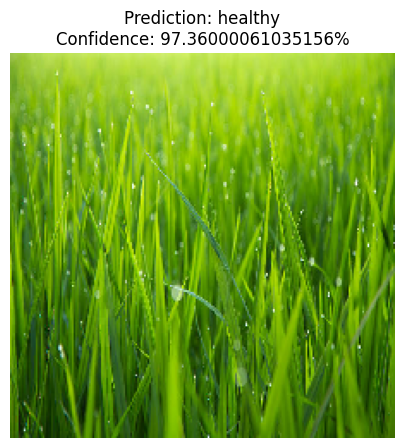

In [24]:
display_img = (img_array[0] * 255).astype(np.uint8)

plt.figure(figsize=(5,5))
plt.imshow(display_img)
plt.axis("off")
plt.title(f"Prediction: {prediction}\nConfidence: {round(confidence, 2)}%")
plt.show()


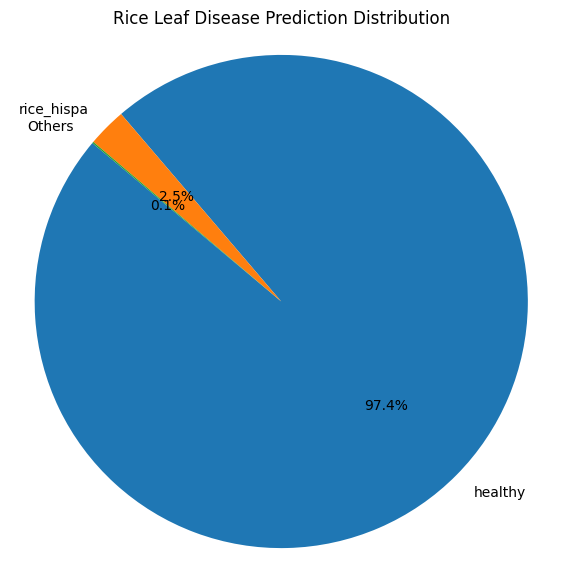

In [25]:
probs = rslt[0]
labels = class_labels

sorted_idx = np.argsort(probs)[::-1]
sorted_probs = probs[sorted_idx]
sorted_labels = np.array(labels)[sorted_idx]

threshold = 0.02
main_probs, main_labels = [], []
others_prob = 0

for p, l in zip(sorted_probs, sorted_labels):
    if p >= threshold:
        main_probs.append(p)
        main_labels.append(l)
    else:
        others_prob += p

if others_prob > 0:
    main_probs.append(others_prob)
    main_labels.append("Others")

plt.figure(figsize=(7,7))
plt.pie(main_probs, labels=main_labels, autopct='%1.1f%%', startangle=140)
plt.title("Rice Leaf Disease Prediction Distribution")
plt.axis('equal')
plt.show()


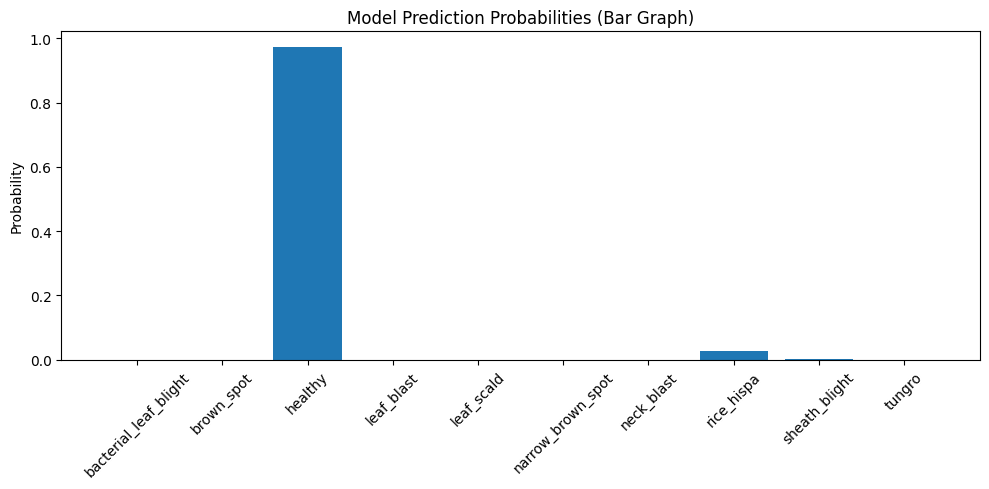

In [26]:
plt.figure(figsize=(10,5))
plt.bar(class_labels, rslt[0])
plt.xticks(rotation=45)
plt.ylabel("Probability")
plt.title("Model Prediction Probabilities (Bar Graph)")
plt.tight_layout()
plt.show()


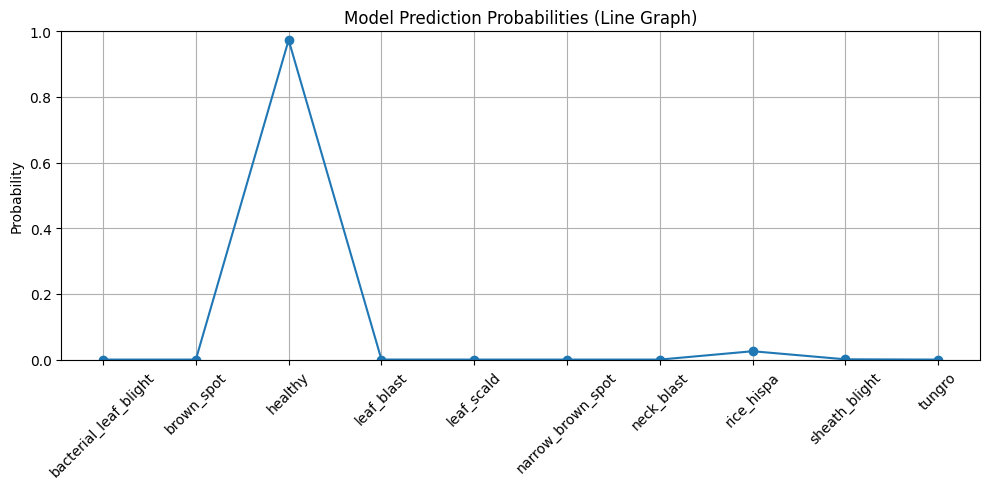

In [27]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.plot(class_labels, rslt[0], marker='o', linestyle='-')
plt.xticks(rotation=45)
plt.ylabel("Probability")
plt.ylim(0, 1)
plt.title("Model Prediction Probabilities (Line Graph)")
plt.grid(True)
plt.tight_layout()
plt.show()
